In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import trompy as tp

ctl_color= "black"
exp_color="deepskyblue"


# the next two lines will expand the printed tables
pd.options.display.max_rows= 40000
pd.options.display.max_columns= 40000

fig_folder= r"C:\Users\hta031\OneDrive - UiT Office 365\Documents\People\Hamid\Presentations\2023\08_August\EBBS\EBBS_FIGS\\"
#f.savefig(figfolder + "timeline pellets delievered+.pdf")


import matplotlib as mpl
mpl.rcParams['font.size'] = 16.0
# mpl.rcParams['axes.labelsize'] = 'medium'
# mpl.rcParams['ytick.labelsize'] = 'small'
# mpl.rcParams['savefig.transparent'] = True
# mpl.rc('lines', linewidth=0.75)
# mpl.rc('axes', linewidth=0.75, edgecolor="k", labelsize=9)


In [2]:
DATA_FOLDER = "..\\data"
df = pd.read_csv(os.path.join(DATA_FOLDER, "FED001_091022_00.CSV"))

def tweak_fed(df):
    
    return (df
             .rename(columns={"MM:DD:YYYY hh:mm:ss": "t",
                             "InterPelletInterval": "ipi"})
             .assign(t=lambda df_: pd.to_datetime(df_.t))
             .set_index("t")
             .query("Event == 'Pellet'")
              .loc["2022-09-12 08:00:00":] # cuts off training phase
             .loc[:,"ipi"] # could use .loc[:,["ipi", "col2", "col5" etc]] to get mutliple columns, e.g. animal name etc
           )
#tweak_fed(df) # could add animal name from metafile and diet and phase so these are returned in dataframe

In [3]:
# read in metafile and put pellets dataframe in keys of a dict
METAFILE = "..\\FEDXC_METAFILE.xls"
rows, header = tp.metafilereader(METAFILE, sheetname="METAFILE")

ff_dict = {}
for row in rows:
    # file, mouse, diet, mode, sex,order,epoch = row
    fedfile, mouse, diet, mode, sex,order,epoch = row
    if (mode == "FF") and (diet in ["NR", "PR"]):
        key = "_".join([mouse, epoch])
        ff_dict[key] = {}
        ff_dict[key]["mouse"] = mouse
        ff_dict[key]["diet"] = diet
        ff_dict[key]["sex"] = sex
        ff_dict[key]["epoch"] = epoch
        ff_dict[key]["order"] = int(order)
        ff_dict[key]["pellets"] = tweak_fed(pd.read_csv(os.path.join(DATA_FOLDER, fedfile)))  


File is excel file. Making csv metafile first


In [4]:
mice=[]
for key in ff_dict.keys():
    
    mouse= key.split("_")[0]
    if mouse not in mice:
        mice.append(mouse)

In [5]:
ff_dict_all_epochs={}
for mouse in mice:
    ff_dict_all_epochs[mouse]={}
    temp=[]
    for key, val in ff_dict.items():
        if mouse in key:
            temp.append(val["pellets"])
            ff_dict_all_epochs [mouse]["order"]= val["order"]
            
    ff_dict_all_epochs[mouse]["pellets"]=pd.concat(temp)       

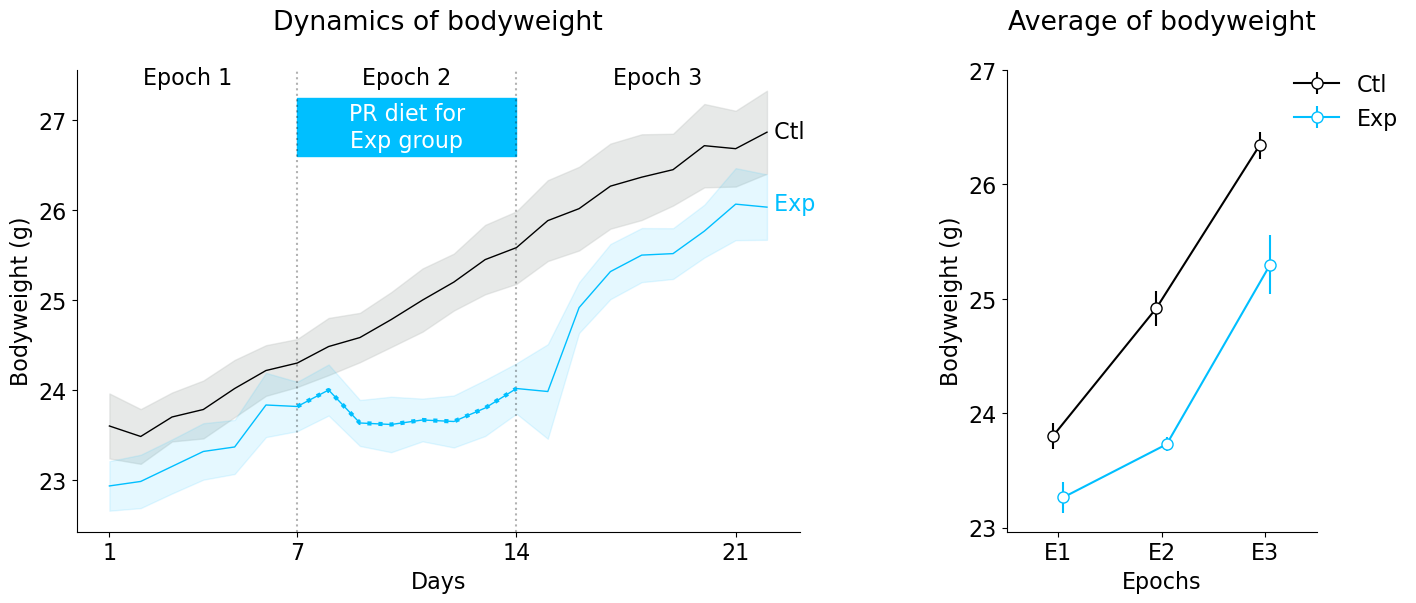

In [9]:
#gets bpdy weight data from the Metafile 
BW_DF=pd.read_excel(r"C:\Users\hta031\Github\FEDPROTEINPRO\METAFILE FEDXC DATA SHEETS.xls" ,sheet_name="METAFILE_BW" )

#divide the mice in Ctl and Exp groups then exclude training and Epoch 4 from the data
ctl=BW_DF.iloc[6:12]
exp=BW_DF.iloc[0:6] 
ctl_E1_3=ctl.iloc[: , 3:25]
exp_E1_3= exp.iloc[: , 3:25]


########################################################
f, [ax1,ax2] = plt.subplots(figsize=(16,6), ncols=2,
                            sharey=False,
                            gridspec_kw={"width_ratios":[0.7,0.3],
                                        "right":0.9, 
                                        "wspace":0.4,
                                        })
tp.shadedError(ax1,ctl_E1_3,linecolor=ctl_color)
tp.shadedError(ax1,exp_E1_3,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)

#tp.shadedError(ax1,exp_pellets.T.iloc[: , 6:14],linecolor="orange", errorcolor= exp_color, alpha= 0, linewidth=1)




######################################################################################
ax1.set_ylabel("Bodyweight (g)")
ax1.set_xlabel("Days")
ax1.axvline(6,color="k",linestyle=":", alpha= 0.3)
ax1.axvline(13,color="k",linestyle=":", alpha= 0.3)
ax1.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax1.text(2.5,27.4,"Epoch 1", ha="center")
ax1.text(9.5,27.4,"Epoch 2", ha="center")
ax1.text(17.5,27.4,"Epoch 3", ha="center")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

#adding a highlight bar at the top of EPOCH 2
ax1.fill_betweenx([27.25,26.6],[6], [13], color = "deepskyblue")
ax1.text(9.5,27.2,"PR diet for\nExp group", color="white",va="top", ha="center")
# x=np.arange(6,14)
# y=exp_E1_3.iloc[:,7:13].mean(axis=0)
# ax1.plot(x, y,
#          linewidth=3,
#          color=exp_color,
#          linestyle=":")

# fed_cols = [ctl_color,exp_color]
# Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
# Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
# ax1.legend(handles=[Ctl_patch, Exp_patch],
#              bbox_to_anchor=(0.67,1),
#              bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_E1_3.iloc[:,0:6].mean(axis=0)
ctl_E2=ctl_E1_3.iloc[:,7:13].mean(axis=0)
ctl_E3=ctl_E1_3.iloc[:,14:21].mean(axis=0)

exp_E1=exp_E1_3.iloc[:,0:6].mean(axis=0)
exp_E2=exp_E1_3.iloc[:,7:13].mean(axis=0)
exp_E3=exp_E1_3.iloc[:,14:21].mean(axis=0)


#adds highlight on the line plot for Exp epoch 2
x=np.arange(6,14)
y=exp_E1_3.iloc[:,6:14].mean(axis=0)
ax1.plot(x, y,
         linewidth=3,
         color=exp_color,
         linestyle=":")
##################################################################################

spacing=0.05
ax2.errorbar([1-spacing,2-spacing,3-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem()],
            marker="o",
            markerfacecolor="white",
             ms=8,
            linestyle="-",
            color=ctl_color,
             label="Ctl",
             
            )

ax2.errorbar([1+spacing,2+spacing,3+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem()],
            marker="o",
             markerfacecolor="white",
             ms=8,
            linestyle="-",
            color=exp_color,
            label="Exp")

ax2.set_xticks([1,2,3],labels=["E1", "E2", "E3"])
ax2.set_xlim([0.5,3.5])
ax2.set_yticks([23,24,25,26,27])
ax2.set_ylabel("Bodyweight (g)")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend(loc=(0.9,0.85), frameon=False)
ax2.set_xlabel("Epochs")
ax1.set_title("Dynamics of bodyweight",  y= 1.07)
ax2.set_title("Average of bodyweight",  y= 1.07)

# f.subplots_adjust(wspace=0.4)


ax1.annotate(" Ctl",[21,26.8])
ax1.annotate(" Exp",[21,26], color= exp_color)

f.savefig(fig_folder + "bodyweight_trend.pdf")

In [8]:
BW_DF

,mouseid,day0,day1,day2,day3,day4,day5,day6,day7,day8,day9,day10,day11,day12,day13,day14,day15,day16,day17,day18,day19,day20,day21,day22,day23,day24,day25,day26,day27,day28,day29,day30
0,FEDXC01,23.6,23.4,22.6,22.9,22.8,23.0,23.3,23.6,23.6,24.0,23.8,23.3,23.2,23.2,23.3,23.3,24.0,24.5,25.1,25.1,25.3,25.3,25.7,26.1,26.1,25.1,25.2,25.7,25.5,25.7,25.4
1,FEDXC02,22.6,23.5,23.0,23.1,23.5,23.3,23.5,24.0,23.9,24.1,24.0,24.2,24.0,24.0,24.3,24.5,24.7,25.7,25.8,26.0,26.0,26.3,26.9,26.5,26.3,26.0,26.0,26.1,26.5,26.8,26.7
2,FEDXC03,22.1,22.2,21.9,21.8,22.2,22.8,22.6,22.6,22.9,23.0,22.6,22.4,23.1,22.9,22.7,23.4,21.6,24.2,24.5,24.8,24.8,25.0,24.9,24.5,24.9,24.8,24.3,24.8,24.7,24.8,25.3
3,FEDXC04,23.6,23.7,24.1,24.1,24.4,24.7,24.6,25.4,24.8,25.2,24.6,24.8,24.8,25.0,25.1,25.2,25.9,26.0,26.7,26.9,26.8,27.1,27.8,27.4,27.1,27.3,27.5,27.2,25.8,27.0,27.7
4,FEDXC05,22.1,22.8,22.7,22.5,22.5,22.3,22.4,23.2,23.2,23.4,23.2,23.3,23.4,23.1,23.5,23.5,23.7,24.8,24.6,24.9,24.9,25.3,25.4,25.5,25.6,25.5,25.0,25.1,25.3,25.7,25.7
5,FEDXC06,23.6,23.9,23.3,23.5,23.5,23.8,23.8,24.2,24.5,24.3,23.6,23.7,23.5,23.7,23.9,24.2,24.0,24.3,25.2,25.3,25.3,25.6,25.7,26.2,25.9,26.2,25.9,26.0,26.3,26.7,26.9
6,FEDXC07,24.6,24.3,25.1,24.9,24.7,25.1,24.8,25.1,24.8,25.4,25.3,25.3,25.5,25.6,26.0,26.3,26.7,26.8,26.8,27.0,27.0,27.2,27.2,27.5,27.4,26.8,26.8,26.8,27.0,27.1,27.3
7,FEDXC08,23.1,23.1,23.0,22.7,22.9,22.9,23.2,23.5,23.6,23.7,23.9,23.9,23.9,24.2,24.5,24.1,24.4,24.5,24.7,24.8,25.1,25.0,25.2,25.5,25.9,25.7,26.0,26.0,25.8,25.9,26.1
8,FEDXC09,22.9,23.0,22.8,23.1,23.8,23.5,23.3,23.9,24.0,24.1,24.3,24.6,24.8,24.5,25.0,25.3,25.4,25.8,25.9,25.8,26.1,26.6,26.7,26.2,26.2,26.6,26.4,26.7,26.2,26.3,26.2
9,FEDXC10,23.1,23.5,23.9,23.7,23.9,23.7,24.4,24.6,24.6,24.5,24.6,25.3,25.5,25.9,26.2,26.5,26.9,27.1,27.5,27.5,26.5,27.6,26.6,27.1,27.4,27.6,27.7,27.5,27.4,27.6,27.3


Text(20, 195, ' Exp')

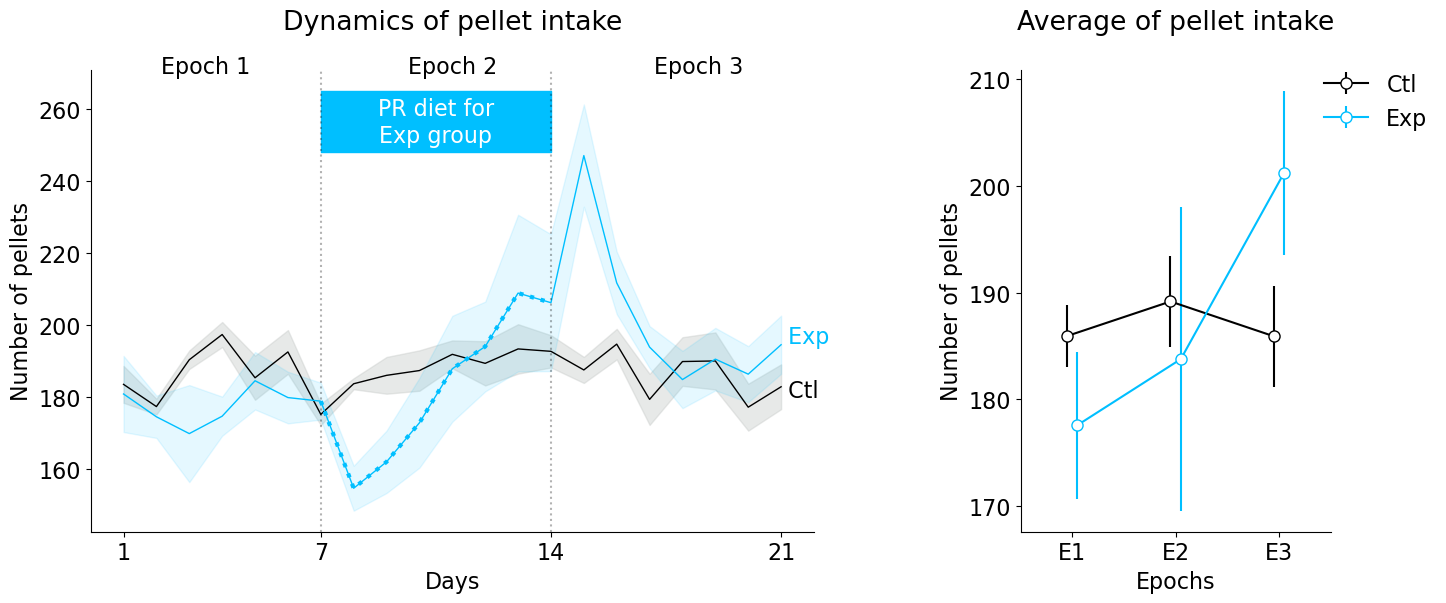

In [6]:
def pellets_by_day(df,maxdays=30):
    return (df
            .rename(index="n_pellets")
            .resample("d", offset = "8H")
            .count()
            .head(maxdays)#We need to add the final two rows instead of deleting last row 
            #.reset_index()
            
           )
ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(pellets_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(pellets_by_day(val["pellets"]))  
        

def clean_df(lst):
    return (pd.concat(lst, axis= 1)
           .fillna(0)
            .reset_index()
            .iloc[:,1:]
           .head(21)) #21 days used because in epoch 4 we used expired pellets for ctl animals and data is excluded, more over the first 2 days of training not covered by the code

ctl_pellets= clean_df(ctl)
exp_pellets= clean_df(exp)

#######plotting the trend of pellet intake in the first 3 weeks in Ctl and Exp mice########################################


f, [ax1,ax2] = plt.subplots(figsize=(16,6), ncols=2,
                            sharey=False,
                            gridspec_kw={"width_ratios":[0.7,0.3],
                                         "right":0.9, 
                                        "wspace":0.4})
                            
tp.shadedError(ax1,ctl_pellets.T,linecolor=ctl_color)
tp.shadedError(ax1,exp_pellets.T,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)


######################################################################################
ax1.set_ylabel("Number of pellets")
ax1.set_xlabel("Days")
ax1.axvline(6,color="k",linestyle=":", alpha= 0.3)
ax1.axvline(13,color="k",linestyle=":", alpha= 0.3)
ax1.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax1.text(2.5,270,"Epoch 1", ha="center")
ax1.text(10,270,"Epoch 2", ha="center")
ax1.text(17.5,270,"Epoch 3", ha="center")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)


#adding a highlight bar at the top of EPOCH 2
ax1.fill_betweenx([248,265],[6], [13], color = "deepskyblue")
ax1.text(9.5,263.2,"PR diet for\nExp group", color="white",va="top", ha="center")
x=np.arange(6,14)
y=exp_pellets.iloc[6:14,:].T.mean(axis=0)
ax1.plot(x, y,
         linewidth=3,
         color=exp_color,
         linestyle=":")


# fed_cols = [ctl_color,exp_color]
# Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
# Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
# ax1.legend(handles=[Ctl_patch, Exp_patch],
#              bbox_to_anchor=(0.67,0.88),
#              bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_pellets.iloc[0:7,:].mean(axis=0)
ctl_E2=ctl_pellets.iloc[7:14,:].mean(axis=0)
ctl_E3=ctl_pellets.iloc[14:,:].mean(axis=0)

exp_E1=exp_pellets.iloc[0:7,:].mean(axis=0)
exp_E2=exp_pellets.iloc[7:14,:].mean(axis=0)
exp_E3=exp_pellets.iloc[14:,:].mean(axis=0)


##################################################################################

spacing=0.05

ax2.errorbar([1-spacing,2-spacing,3-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem()],
             marker="o",
             markerfacecolor="white",
             ms=8,
             linestyle="-",
             color=ctl_color,
             label="Ctl",
             
                )



ax2.errorbar([1+spacing,2+spacing,3+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem()],
             marker="o",
             markerfacecolor="white",
             ms=8,
             linestyle="-",
             color=exp_color,
             label="Exp")

ax2.set_xticks([1,2,3],labels=["E1", "E2", "E3"])
ax2.set_xlim([0.5,3.5])
ax2.set_yticks([170,180,190,200,210])
ax2.set_ylabel("Number of pellets")
ax2.set_xlabel("Epochs")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend(loc=2)

ax1.set_title("Dynamics of pellet intake", y=1.07)
ax2.set_title("Average of pellet intake", y=1.07)
ax2.legend(loc=(0.95,0.85), frameon=False)
# f.subplots_adjust(wspace=0.4)

ax1.annotate(" Ctl",[20,180])
ax1.annotate(" Exp",[20,195], color= exp_color)


#f.savefig(fig_folder + "trend_intake.pdf")


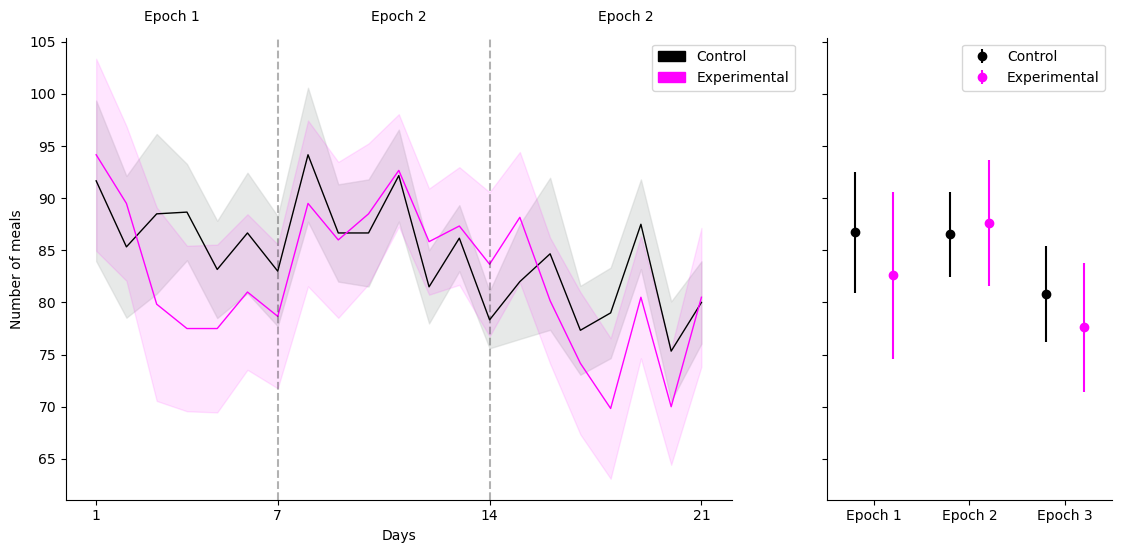

In [31]:
def nmeals_by_day(df):
    return (df
             .rename(index="n_meals")
            .resample("d", offset = "8H")
            .apply(lambda df_: sum(df_ > 60))
            # .reset_index()
            
           )
ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(nmeals_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(nmeals_by_day(val["pellets"]))

ctl_n_meals= clean_df(ctl)
exp_n_meals= clean_df(exp)


#################################################################


f, [ax1,ax2] = plt.subplots(figsize=(13.5,6), ncols=2,
                            sharey=True,
                           gridspec_kw={"width_ratios":[0.7,0.3]})
tp.shadedError(ax1,ctl_n_meals.T,linecolor=ctl_color)
tp.shadedError(ax1,exp_n_meals.T,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1)

######################################################################################
ax1.set_ylabel("Number of meals")
ax1.set_xlabel("Days")
ax1.axvline(6,color="k",linestyle="--", alpha= 0.3)
ax1.axvline(13,color="k",linestyle="--", alpha= 0.3)
ax1.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax1.text(2.5,107,"Epoch 1", ha="center")
ax1.text(10,107,"Epoch 2", ha="center")
ax1.text(17.5,107,"Epoch 2", ha="center")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)



fed_cols = [ctl_color,exp_color]
Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
ax1.legend(handles=[Ctl_patch, Exp_patch],
             bbox_to_anchor=(0.67,0.88),
             bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_n_meals.iloc[0:7,:].mean(axis=0)
ctl_E2=ctl_n_meals.iloc[7:14,:].mean(axis=0)
ctl_E3=ctl_n_meals.iloc[14:,:].mean(axis=0)

exp_E1=exp_n_meals.iloc[0:7,:].mean(axis=0)
exp_E2=exp_n_meals.iloc[7:14,:].mean(axis=0)
exp_E3=exp_n_meals.iloc[14:,:].mean(axis=0)


##################################################################################

spacing=0.2

ax2.errorbar([1-spacing,2-spacing,3-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem()],
            marker="o",
            linestyle="",
            color=ctl_color,
             label="Control")

ax2.errorbar([1+spacing,2+spacing,3+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem()],
            marker="o",
            linestyle="",
            color=exp_color,
            label="Experimental")

ax2.set_xticks([1,2,3],labels=["Epoch 1", "Epoch 2", "Epoch 3"])
ax2.set_xlim([0.5,3.5])

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend()

#f.savefig(fig_folder + "meal_number.png")


Text(20, 2.5, ' Exp')

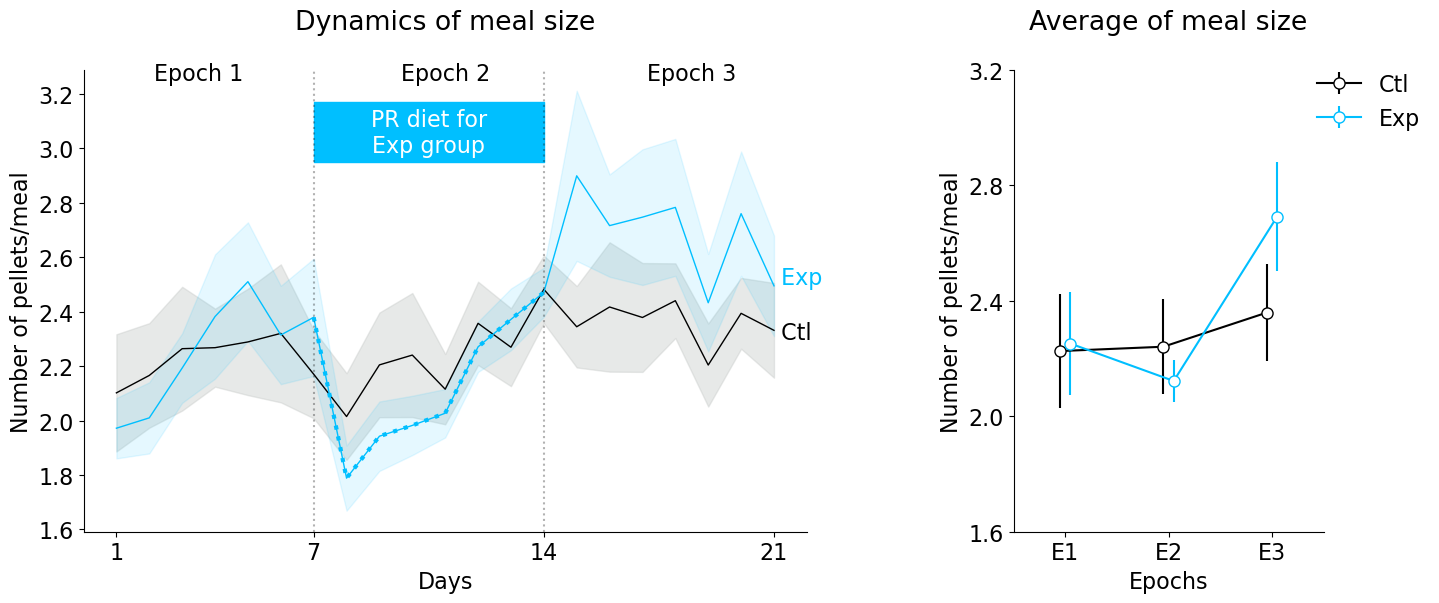

In [12]:
def mealsize_by_day(df):
    return (df
            .rename(index="mealsize")
            .resample("d", offset = "8H")
            .apply(lambda df_: df_.count()/sum(df_ > 60))
            
#              .reset_index()
            
           )
#mealsize_by_day (ff_dict_all_epochs["FEDXC01"]["pellets"])


ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(mealsize_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(mealsize_by_day(val["pellets"]))

ctl_meal_size= clean_df(ctl)

exp_meal_size= clean_df(exp)


#################################################################


f, [ax1,ax2] = plt.subplots(figsize=(16,6), ncols=2,
                            sharey=False,
                           gridspec_kw={"width_ratios":[0.7,0.3],
                                        "right":0.9, 
                                        "wspace":0.4})
tp.shadedError(ax1,ctl_meal_size.T,linecolor=ctl_color)
tp.shadedError(ax1,exp_meal_size.T,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)

######################################################################################
ax1.set_ylabel("Number of pellets/meal")
ax1.set_xlabel("Days")
ax1.axvline(6,color="k",linestyle=":", alpha= 0.3)
ax1.axvline(13,color="k",linestyle=":", alpha= 0.3)
ax1.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax1.text(2.5,3.25,"Epoch 1", ha="center")
ax1.text(10,3.25,"Epoch 2", ha="center")
ax1.text(17.5,3.25,"Epoch 3", ha="center")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)


#adding a highlight bar at the top of EPOCH 2
ax1.fill_betweenx([2.95,3.17],[6], [13], color = "deepskyblue")
ax1.text(9.5,3.15,"PR diet for\nExp group", color="white",va="top", ha="center")
x=np.arange(6,14)
y=exp_meal_size.iloc[6:14,:].T.mean(axis=0)
ax1.plot(x, y,
         linewidth=3,
         color=exp_color,
         linestyle=":")

# fed_cols = [ctl_color,exp_color]
# Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
# Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
# ax1.legend(handles=[Ctl_patch, Exp_patch],
#              bbox_to_anchor=(0.67,0.88),
#              bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_meal_size.iloc[0:7,:].mean(axis=0)
ctl_E2=ctl_meal_size.iloc[7:14,:].mean(axis=0)
ctl_E3=ctl_meal_size.iloc[14:,:].mean(axis=0)

exp_E1=exp_meal_size.iloc[0:7,:].mean(axis=0)
exp_E2=exp_meal_size.iloc[7:14,:].mean(axis=0)
exp_E3=exp_meal_size.iloc[14:,:].mean(axis=0)


##################################################################################

spacing=0.05

ax2.errorbar([1-spacing,2-spacing,3-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem()],
            marker="o",
            linestyle="-",
            markerfacecolor= "white",
            ms=8,
            color=ctl_color,
             label="Ctl")

ax2.errorbar([1+spacing,2+spacing,3+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem()],
            marker="o",
            linestyle="-",
             markerfacecolor="white",
             ms=8,
            color=exp_color,
            label="Exp")

ax2.set_xticks([1,2,3],labels=["E1", "E2", "E3"])
ax2.set_xlim([0.5,3.5])
ax2.set_yticks([1.6,2,2.4,2.8,3.2])
ax2.set_ylabel("Number of pellets/meal")
ax2.set_xlabel("Epochs")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend(loc=(0.95,0.85), frameon=False)

ax1.set_title("Dynamics of meal size", y=1.07)
ax2.set_title("Average of meal size",y=1.07)

# f.subplots_adjust(wspace=0.4)

ax1.annotate(" Ctl",[20,2.3])
ax1.annotate(" Exp",[20,2.5], color= exp_color)

#f.savefig(fig_folder + "mealsize.pdf")



Text(20, 3.4, ' Exp')

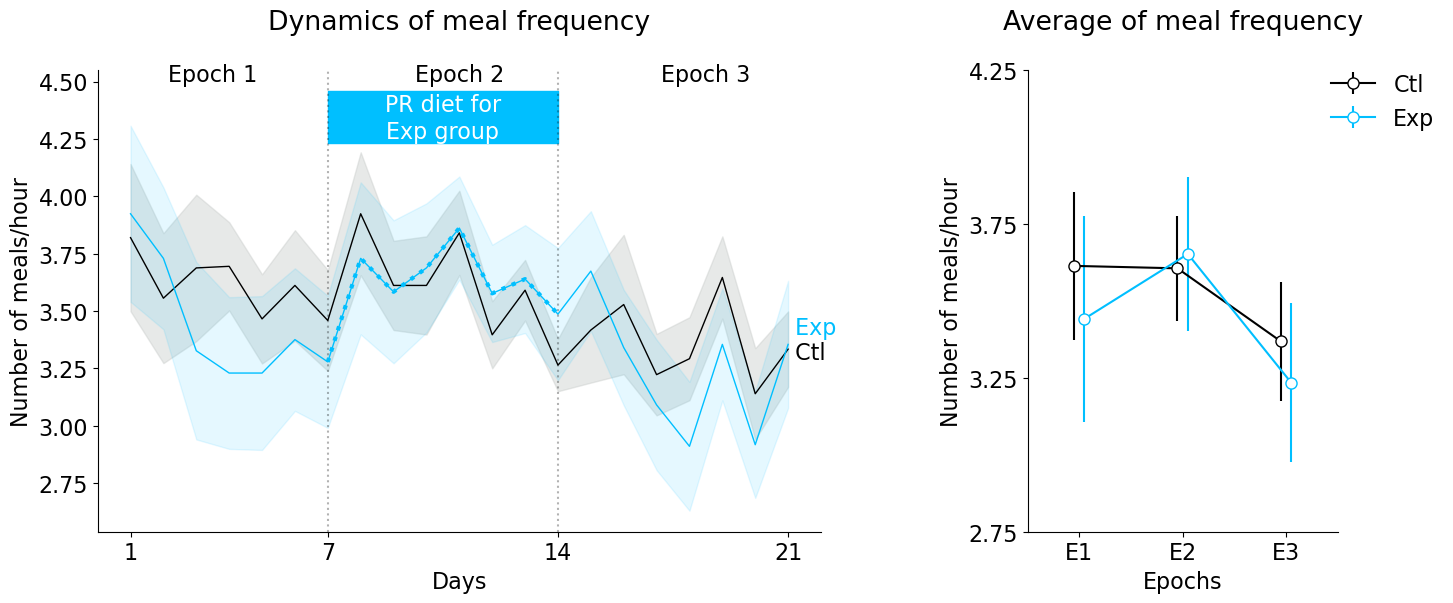

In [13]:
#######Calculates meal frequency 



def nmeals_by_day(df):
    return (df
             .rename(index="n_meals")
            .resample("d", offset = "8H")
            .apply(lambda df_: sum(df_ > 60))
            # .reset_index()
            
           )
ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(nmeals_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(nmeals_by_day(val["pellets"]))
##################################################################################
ctl_freq=[]
for x in ctl:
    ctl_freq.append(x/24) 
    # print(ctl_freq)
    
exp_freq=[]
for x in exp:
    exp_freq.append(x/24)
    # print(exp_freq)
    
#####################################################################################

ctl_t_freq= clean_df(ctl_freq)
exp_t_freq= clean_df(exp_freq)


###################################################################################


f, [ax1,ax2] = plt.subplots(figsize=(16,6), ncols=2,
                            sharey=False,
                           gridspec_kw={"width_ratios":[0.7,0.3],
                                        "right":0.9, 
                                        "wspace":0.4})
tp.shadedError(ax1,ctl_t_freq.T,linecolor=ctl_color)
tp.shadedError(ax1,exp_t_freq.T,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)

######################################################################################
ax1.set_ylabel("Number of meals/hour")
ax1.set_xlabel("Days")
ax1.axvline(6,color="k",linestyle=":", alpha= 0.3)
ax1.axvline(13,color="k",linestyle=":", alpha= 0.3)
ax1.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax1.text(2.5,4.50,"Epoch 1", ha="center")
ax1.text(10,4.50,"Epoch 2", ha="center")
ax1.text(17.5,4.50,"Epoch 3", ha="center")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)


#adding a highlight bar at the top of EPOCH 2
ax1.fill_betweenx([4.23,4.46],[6], [13], color = "deepskyblue")
ax1.text(9.5,4.45,"PR diet for\nExp group", color="white",va="top", ha="center")
x=np.arange(6,14)
y=exp_t_freq.iloc[6:14,:].T.mean(axis=0)
ax1.plot(x, y,
         linewidth=3,
         color=exp_color,
         linestyle=":")

# fed_cols = [ctl_color,exp_color]
# Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
# Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
# ax1.legend(handles=[Ctl_patch, Exp_patch],
#              bbox_to_anchor=(0.67,0.88),
#              bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_t_freq.iloc[0:7,:].mean(axis=0)
ctl_E2=ctl_t_freq.iloc[7:14,:].mean(axis=0)
ctl_E3=ctl_t_freq.iloc[14:,:].mean(axis=0)

exp_E1=exp_t_freq.iloc[0:7,:].mean(axis=0)
exp_E2=exp_t_freq.iloc[7:14,:].mean(axis=0)
exp_E3=exp_t_freq.iloc[14:,:].mean(axis=0)


##################################################################################

spacing=0.05

ax2.errorbar([1-spacing,2-spacing,3-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem()],
            marker="o",
            linestyle="-",
            markerfacecolor= "white",
            ms=8,
            color=ctl_color,
             label="Ctl")

ax2.errorbar([1+spacing,2+spacing,3+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem()],
            marker="o",
            linestyle="-",
             markerfacecolor="white",
             ms=8,
            color=exp_color,
            label="Exp")

ax2.set_xticks([1,2,3],labels=["E1", "E2", "E3"])
ax2.set_xlim([0.5,3.5])
ax2.set_yticks([2.75,3.25,3.75,4.25])
ax2.set_ylabel("Number of meals/hour")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend(loc=(0.95,0.85), frameon=False)
ax2.set_xlabel("Epochs")
ax1.set_title("Dynamics of meal frequency", y=1.07)
ax2.set_title("Average of meal frequency",y=1.07)

# f.subplots_adjust(wspace=0.4)

ax1.annotate(" Ctl",[20,3.29])
ax1.annotate(" Exp",[20,3.40], color= exp_color)

#f.savefig(fig_folder + "meal_freq.pdf")


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


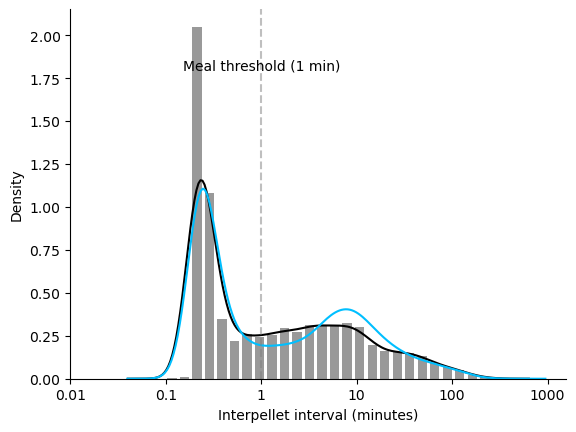

In [13]:

all_ipis = []
for key, data in ff_dict.items():
#     print(key, len(data["pellets"]))
    all_ipis.append(data["pellets"].dropna().clip(1))
    
all_ipis = pd.concat(all_ipis)


# get all IPIs for distribution histogram

ipis_ALL = []
NR_IPIS = []
PR_IPIS = []
for key, data in ff_dict.items():
    
    if data ["epoch"] == "E2":
        if data ["diet"] == "NR":
            NR_IPIS.append(data["pellets"].dropna().clip(1))
        elif  data ["diet"] == "PR":
            PR_IPIS.append(data["pellets"].dropna().clip(1))
    

NR_IPIS = pd.concat(NR_IPIS)
PR_IPIS = pd.concat(PR_IPIS)
ipis_ALL= pd.concat([PR_IPIS, NR_IPIS] )




#converge PR and NR KDE
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]
# trans_ipisALL = [ipi for ipi in np.log10(all_ipis/60) if np.isfinite(ipi)]
f, ax = plt.subplots()


data = sns.distplot(trans_ipisNR, color = ctl_color, hist = True, hist_kws={"rwidth":0.75} )
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


data = sns.distplot(trans_ipisPR, color= exp_color, hist = False, kde=True )
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])



# data = sns.distplot(trans_ipisALL, color = "grey", hist = False , kde = True)
# ax.set_xlabel("Interpellet interval (minutes)")
# ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])

#sns.set_style("white")
#sns.set(rc={"figure.figsize":(13, 6)}) 




ax.axvline(0, linestyle="--", color="grey", alpha=0.5)
ax.text(0,1.8, "Meal threshold (1 min)", ha="center")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

#f.savefig(fig_folder + "KDE.png")


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


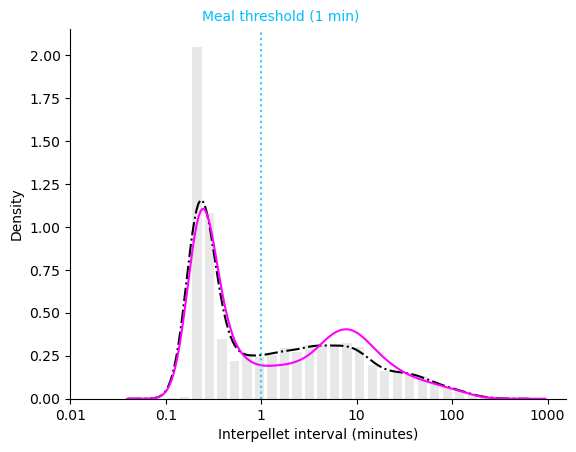

In [8]:
# Control Epoch 2 NR vs Experimental Epoch 2 NR
all_ipis = []
for key, data in ff_dict.items():
#     print(key, len(data["pellets"]))
    all_ipis.append(data["pellets"].dropna())
    
all_ipis = pd.concat(all_ipis)


# get all IPIs for distribution histogram

ipis_ALL = []
NR_IPIS = []
PR_IPIS = []
for key, data in ff_dict.items():
    
    if data ["epoch"] == "E2":
        if data ["diet"] == "NR":
            NR_IPIS.append(data["pellets"].dropna().clip(1))
        elif  data ["diet"] == "PR":
            PR_IPIS.append(data["pellets"].dropna().clip(1))
    

NR_IPIS = pd.concat(NR_IPIS)
PR_IPIS = pd.concat(PR_IPIS)
ipis_ALL= pd.concat([PR_IPIS, NR_IPIS] )




#converge PR and NR KDE
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]
# trans_ipisALL = [ipi for ipi in np.log10(all_ipis/60) if np.isfinite(ipi)]
f, ax = plt.subplots()


data = sns.distplot(trans_ipisNR, color = ctl_color, hist = True, 
                    hist_kws={"rwidth":0.75, 
                              'color':ctl_color, "alpha":0.09},
                    kde_kws={'linestyle':'-.'})
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


data = sns.distplot(trans_ipisPR, color= exp_color, hist = False, kde=True )
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])



# data = sns.distplot(trans_ipisALL, color = "grey", hist = False , kde = True)
# ax.set_xlabel("Interpellet interval (minutes)")
# ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


ax.axvline(0, linestyle=":", color="deepskyblue", alpha=0.8)
ax.text(0.2,2.2, "Meal threshold (1 min)", ha="center", color="deepskyblue")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)



#f.savefig(fig_folder + "KDE_V2.png")


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


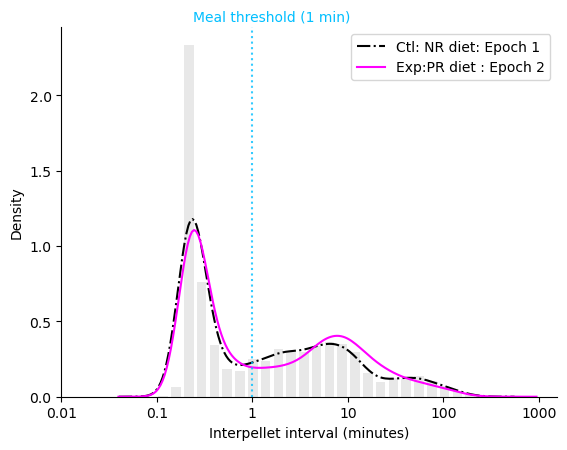

In [10]:
#Control Epoch 1 NR vs Experimental Epoch 2 PR
all_ipis = []
for key, data in ff_dict.items():
#     print(key, len(data["pellets"]))
    all_ipis.append(data["pellets"].dropna())
    
all_ipis = pd.concat(all_ipis)


# get all IPIs for distribution histogram

ipis_ALL = []
NR_IPIS = []
PR_IPIS = []
for key, data in ff_dict.items():
    
    if data ["epoch"] == "E1":
        if data ["order"] == 1:
            if data ["diet"] == "NR":
                NR_IPIS.append(data["pellets"].dropna().clip(1))
    if data ["epoch"] == "E2":
        if data ["diet"] == "PR":
            PR_IPIS.append(data["pellets"].dropna().clip(1))
    
    
       
    

NR_IPIS = pd.concat(NR_IPIS)
PR_IPIS = pd.concat(PR_IPIS)
ipis_ALL= pd.concat([PR_IPIS, NR_IPIS] )




#converge PR and NR KDE
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]
# trans_ipisALL = [ipi for ipi in np.log10(all_ipis/60) if np.isfinite(ipi)]
f, ax = plt.subplots()


data = sns.distplot(trans_ipisNR, color = ctl_color, hist = True,
                    hist_kws={"rwidth":0.75, 
                              'color':ctl_color, "alpha":0.09},
                    kde_kws={'linestyle':'-.' ,"shade":False, "label" : "Ctl: NR diet: Epoch 1"})

ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


data2 = sns.distplot(trans_ipisPR, color= exp_color, hist = False, kde=True , label ="Exp:PR diet : Epoch 2")
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])



# data = sns.distplot(trans_ipisALL, color = "grey", hist = False , kde = True)
# ax.set_xlabel("Interpellet interval (minutes)")
# ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


ax.axvline(0, linestyle=":", color="deepskyblue", alpha=0.8)
ax.text(0.2,2.5, "Meal threshold (1 min)", ha="center", color="deepskyblue")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend()

#f.savefig(fig_folder + "KDE_V2.png")


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


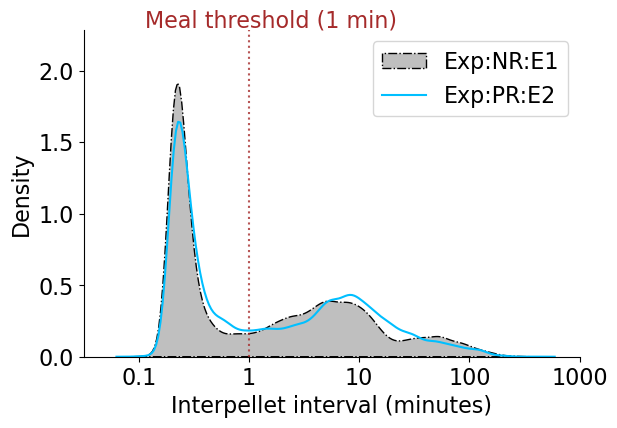

In [34]:
################## Experimental group NR diet Epoch 1 vs Epxerimental group PR diet Epoch 2
all_ipis = []
for key, data in ff_dict.items():
#     print(key, len(data["pellets"]))
    all_ipis.append(data["pellets"].dropna())
    
all_ipis = pd.concat(all_ipis)


# get all IPIs for distribution histogram

ipis_ALL = []
NR_IPIS = []
PR_IPIS = []
for key, data in ff_dict.items():
    
    if data ["epoch"] == "E1":
        if data ["order"] == 2:
            if data ["diet"] == "NR":
                NR_IPIS.append(data["pellets"].dropna().clip(1))
    if data ["epoch"] == "E2":
        if data ["diet"] == "PR":
            PR_IPIS.append(data["pellets"].dropna().clip(1))
    
    
       
    

NR_IPIS = pd.concat(NR_IPIS)
PR_IPIS = pd.concat(PR_IPIS)
ipis_ALL= pd.concat([PR_IPIS, NR_IPIS] )




#converge PR and NR KDE
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]
# trans_ipisALL = [ipi for ipi in np.log10(all_ipis/60) if np.isfinite(ipi)]
f, ax = plt.subplots(gridspec_kw={"bottom":0.2})


data = sns.distplot(trans_ipisNR, color = ctl_color, hist = False, 
                    hist_kws={"rwidth":0.75, 
                              'color':ctl_color, "alpha":0.09},
                    kde_kws={'linestyle':'-.', "shade":True,"bw_adjust":0.5}, label ="Exp:NR:E1")
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])

data = sns.distplot(trans_ipisPR, color= exp_color, hist = False, kde=True, label = "Exp:PR:E2" ,
                   kde_kws={"bw_adjust":0.5})
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])
ax.set_yticks([0,0.5,1,1.5,2])
ax.set_xlim([-1.5,3])
ax.set_ylim(0.0, 2.2809548671887865)

# data = sns.distplot(trans_ipisALL, color = "grey", hist = False , kde = True)
# ax.set_xlabel("Interpellet interval (minutes)")
# ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


ax.axvline(0, linestyle=":", color="brown", alpha=0.8)
ax.text(0.2,2.3, "Meal threshold (1 min)", ha="center", color="brown")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend()

#sns.set(rc={'figure.figsize':(3,6.5)})


f.savefig(fig_folder + "KDE_Hist_E1EXP_VS_E2EXP.pdf")


In [27]:
ax.get_ylim()

(0.0, 2.00926054909078)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


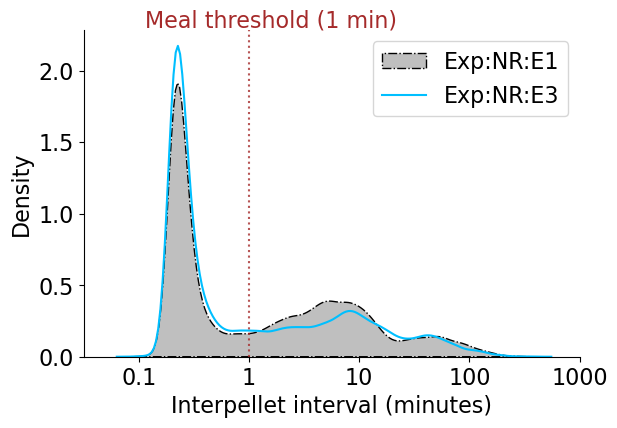

In [28]:
#Experimental group Epoch 1 NR vs Experimental group Epoch 3 NR
all_ipis = []
for key, data in ff_dict.items():
#     print(key, len(data["pellets"]))
    all_ipis.append(data["pellets"].dropna())
    
all_ipis = pd.concat(all_ipis)


# get all IPIs for distribution histogram

ipis_ALL = []
NR_IPIS = []
PR_IPIS = []
for key, data in ff_dict.items():
    
    if data ["epoch"] == "E1":
        if data ["order"] == 2:
            if data ["diet"] == "NR":
                NR_IPIS.append(data["pellets"].dropna().clip(1))
    if data ["epoch"] == "E3":
        if data["order"] == 2:
            if data ["diet"] == "NR":
                PR_IPIS.append(data["pellets"].dropna().clip(1))
    
    
       
    

NR_IPIS = pd.concat(NR_IPIS)
PR_IPIS = pd.concat(PR_IPIS)
ipis_ALL= pd.concat([PR_IPIS, NR_IPIS] )




#converge PR and NR KDE
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]
# trans_ipisALL = [ipi for ipi in np.log10(all_ipis/60) if np.isfinite(ipi)]
f, ax = plt.subplots(gridspec_kw={"bottom":0.2})


data = sns.distplot(trans_ipisNR, color = ctl_color, hist = False, label = "Exp:NR:E1",
                    hist_kws={"rwidth":0.75, 
                              'color':ctl_color, "alpha":0.09},
                    kde_kws={'linestyle':'-.', "shade":True,"bw_adjust": 0.5})
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


data2 = sns.distplot(trans_ipisPR, color= exp_color, hist = False, kde=True, label= "Exp:NR:E3",
                    kde_kws={"bw_adjust": 0.5})
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])
ax.set_xlim([-1.5,3])


# data = sns.distplot(trans_ipisALL, color = "grey", hist = False , kde = True)
# ax.set_xlabel("Interpellet interval (minutes)")
# ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


ax.axvline(0, linestyle=":", color="brown", alpha=0.8)
ax.text(0.2,2.3, "Meal threshold (1 min)", ha="center", color="brown")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend()

#f.savefig(fig_folder + "KDE_E1EXP_VS_E3EXP.pdf")


In [29]:
ax.get_ylim()

(0.0, 2.2809548671887865)